In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import warnings
import matplotlib.pylab as plt

#import skfuzzy as fuzz

from pyFTS.partitioners import CMeans, Grid, FCM, Huarng, Entropy, Util as pUtil
from pyFTS.common import Membership as mf
from pyFTS.benchmarks import benchmarks as bchmk
from pyFTS.models import hofts, pwfts

from pyFTS.common import Util as cUtil

from pyFTS.common import Transformations
tdiff = Transformations.Differential(1)

%matplotlib inline

In [2]:
dataset = pd.read_excel('Rice_Price_Inflation.xlsx')

In [ ]:
dataset.index = pd.to_datetime(dataset['DATE'])
dataset.drop(columns='DATE',inplace=True)
print(dataset)

In [9]:
data = dataset.drop(columns=['INFLATION','FOOD INFLATION','SECURITY INDEX'])
data.head()


,PRICE
DATE,
2012-05-15,14974.95
2012-06-15,14700.00
2012-07-15,16075.00
2012-08-15,16960.00
2012-09-15,15600.00


In [37]:
ind = np.argsort(data['PRICE'])
sorted_data = data['PRICE'][ind]
d_array = np.array(sorted_data)
d_array[:5]


array([14000., 14000., 14360., 14375., 14525.])

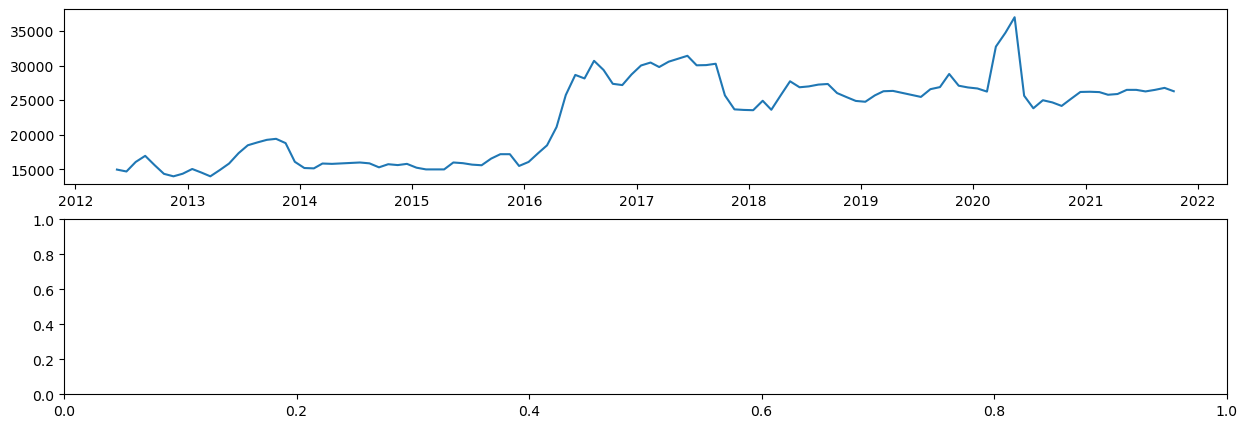

In [39]:
plt.rc('text', usetex=False)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,5])
ax[0].plot(data)
#ax[1].plot(data_diff)

cUtil.show_and_save_image(fig,"Rice_Price",False)

In [28]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [41]:
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.023211
p-value: 0.276489
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581


In [ ]:
dat = bchmk.sliding_window_benchmarks(dataset,12, train=0.8, inc=0.2, methods=[hofts.WeightedHighOrderFTS],
                                benchmark_models=False, orders=[1,2,3], #partitions=np.arange(10,100,5),
                                progress=False, #type='point',
                                #distributed=True, nodes=['192.168.0.102','192.168.0.106','192.168.0.110'],
                                save=True, file="rice_price.csv")

In [ ]:
dat = pd.read_csv("rice_price.csv", sep=";")

from pyFTS.benchmarks import Util as bUtil

dat = bUtil.analytic_tabular_dataframe(dat)

df = dat[dat.Measure == 'RMSE']

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Order'], df['Partitions'], df['Value'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

In [22]:
train_split = 89
test_length = 20

In [42]:
partitioner = Grid.GridPartitioner(data=d_array[:train_split], npart=15)
#partitioner_diff = Grid.GridPartitioner(data=data[:train_split], npart=3, transformation=tdiff)

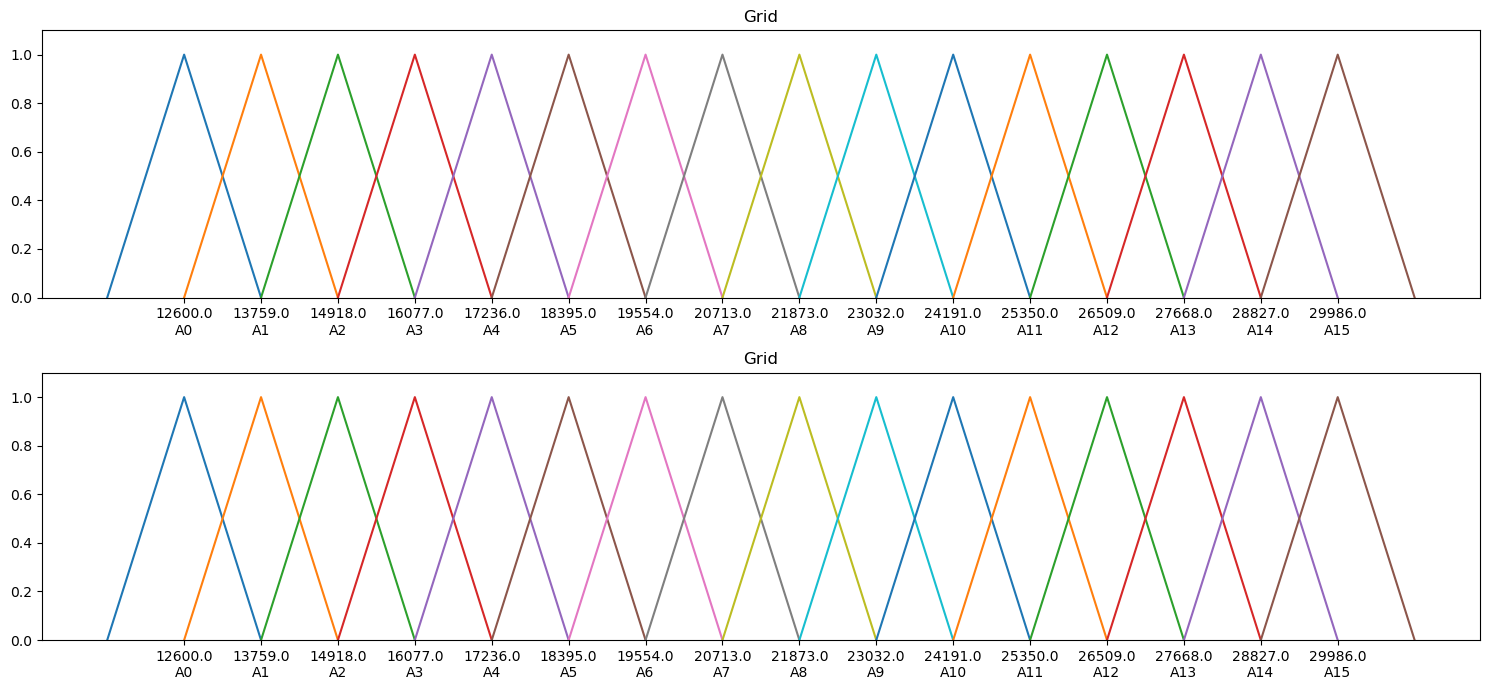

In [43]:
pUtil.plot_partitioners(d_array[:train_split], [partitioner, partitioner], tam=[15,7])

In [44]:
from pyFTS.common import fts,tree

pfts1_rice = pwfts.ProbabilisticWeightedFTS( partitioner=partitioner)
pfts1_rice.fit(d_array[:train_split], save_model=True, file_path='pwfts')
pfts1_rice.shortname = "1st Order"
print(pfts1_rice)

Probabilistic FTS:
(0.035) A1 -> (0.476)A1, (0.524)A2, (0.0)A3
(0.067) A10 -> (0.533)A10, (0.318)A11, (0.002)A12, (0.147)A9
(0.14) A11 -> (0.073)A10, (0.613)A11, (0.314)A12, (0.0)A13
(0.21) A12 -> (0.155)A11, (0.724)A12, (0.121)A13
(0.034) A13 -> (0.538)A12, (0.462)A13
(0.172) A2 -> (0.054)A1, (0.673)A2, (0.273)A3, (0.0)A4
(0.178) A3 -> (0.2)A2, (0.725)A3, (0.074)A4, (0.0)A5
(0.056) A4 -> (0.034)A3, (0.747)A4, (0.205)A5, (0.013)A6
(0.041) A5 -> (0.023)A4, (0.576)A5, (0.368)A6, (0.021)A7, (0.011)A8
(0.029) A6 -> (0.198)A5, (0.46)A6, (0.221)A7, (0.122)A8
(0.007) A7 -> (0.456)A10, (0.544)A9
(0.004) A8 -> (0.456)A10, (0.544)A9
(0.026) A9 -> (0.615)A10, (0.002)A11, (0.383)A9



In [45]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [53]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

labels = sorted(pfts1_rice.flrgs.keys(), key=lambda x: pfts1_rice.sets[x].centroid)
probs = [pfts1_rice.flrg_lhs_unconditional_probability(pfts1_rice.flrgs[k]) for k in labels]

ds = ColumnDataSource(data={'x':labels, 'y': probs})


p = figure(plot_width=40, plot_height=10, title="Rice Price Per 50kg",
           toolbar_location=None, tools="")

#p.vbar(x='x', top='y', width=1, source=ds)

show(p)

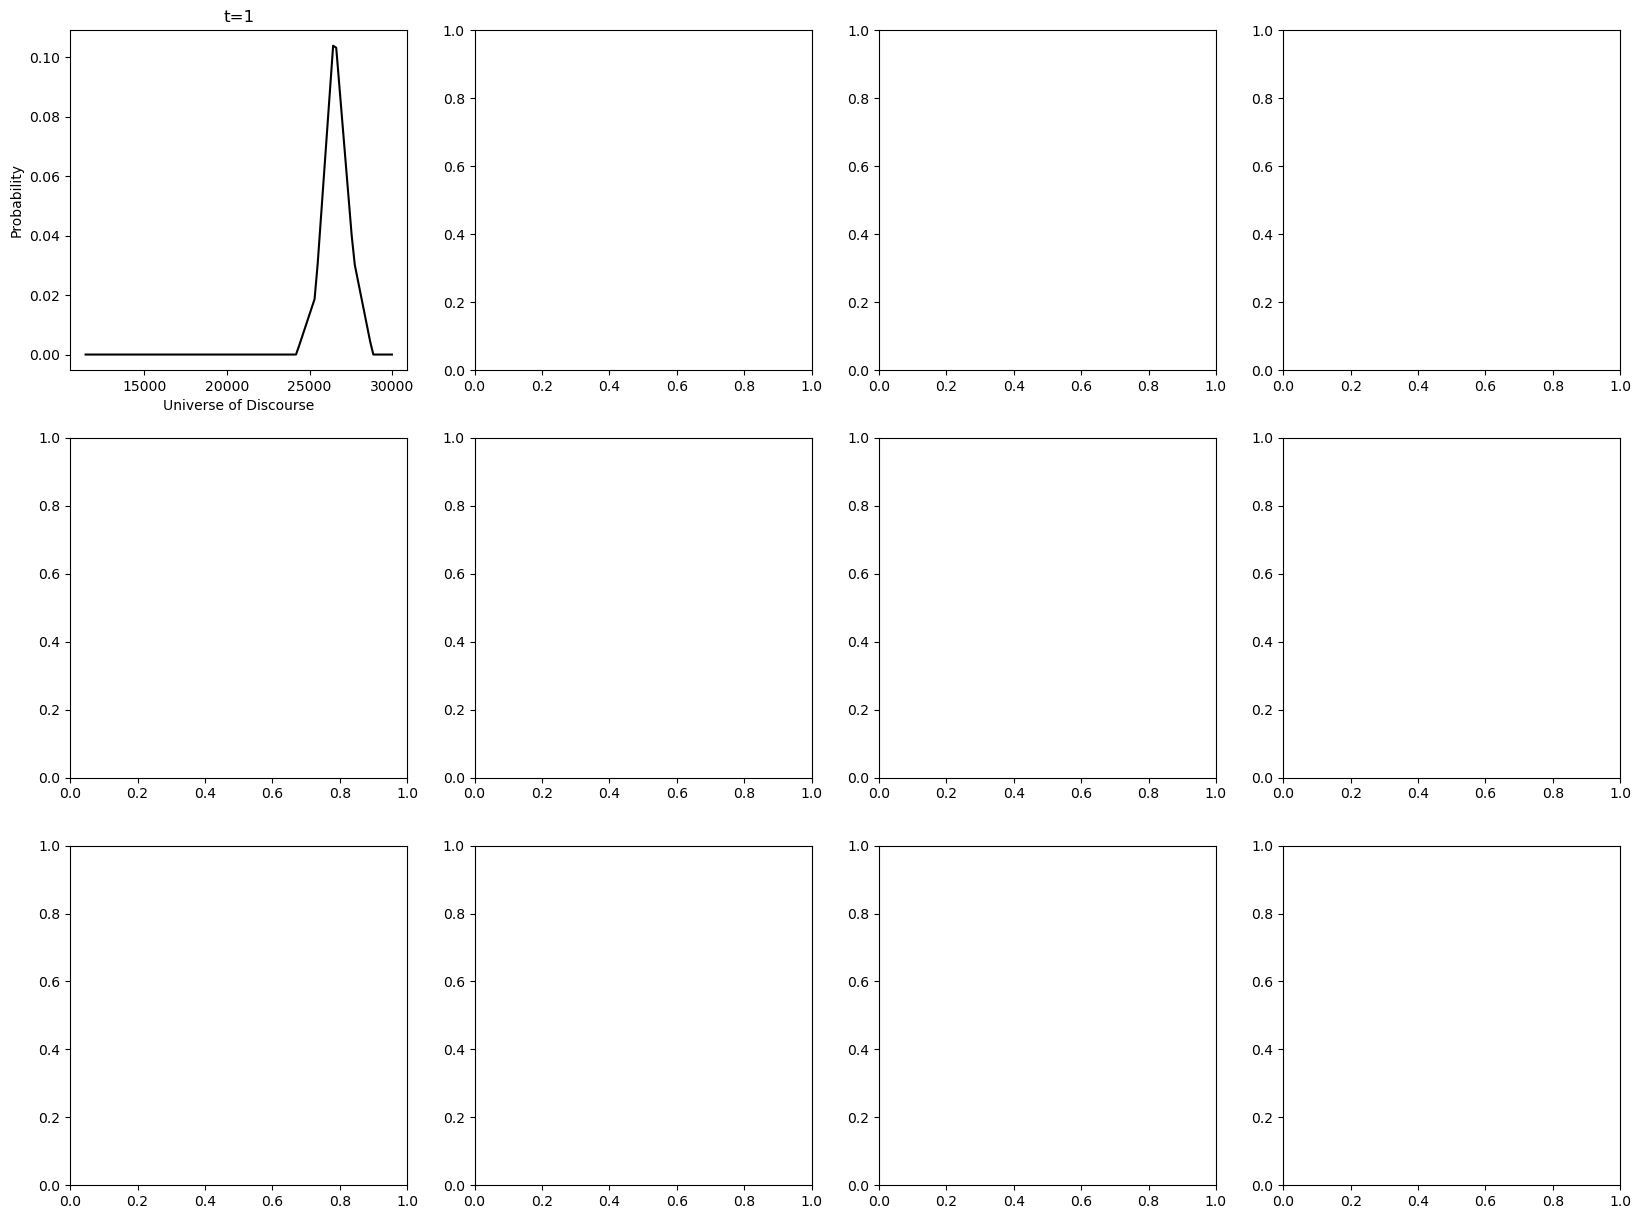

In [51]:
pfts1_rice = cUtil.load_obj('pwfts')
tmp = pfts1_rice.predict(d_array[train_split:train_split+20], type='distribution')
f, ax = plt.subplots(3, 4, figsize=[20,15])
tmp[0].plot(ax[0][0], title='t=1')


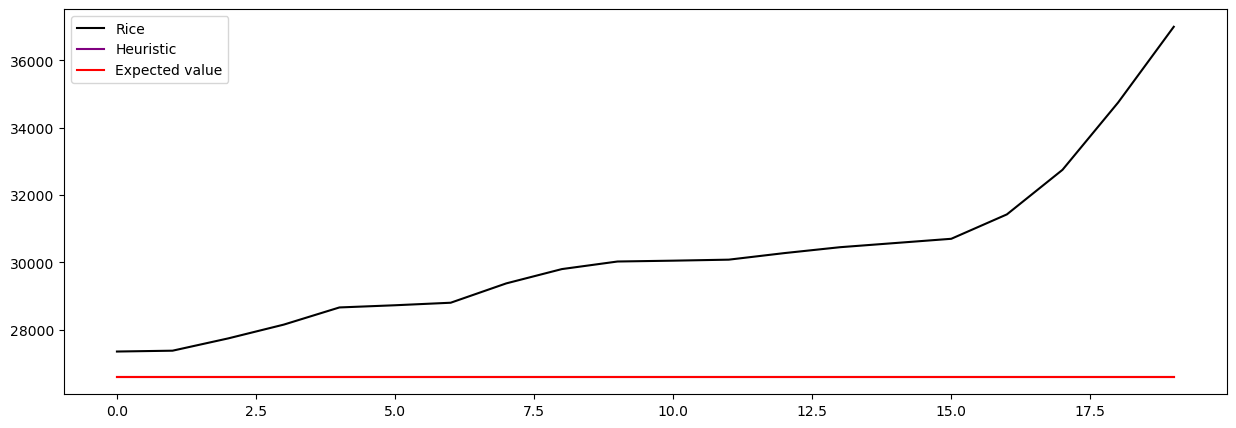

In [55]:
#pfts1_rice = cUtil.load_obj('pwfts')
tmpe = pfts1_rice.predict(d_array[train_split:train_split+20], type='point', method='heuristic')
tmpq = pfts1_rice.predict(d_array[train_split:train_split+20], type='point', method='expected_value')

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,20), d_array[train_split:train_split+20], color="black", label="Rice")


ax.plot(tmpe, color='purple', label="Heuristic")
ax.plot(tmpq, color='red', label="Expected value")

#ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

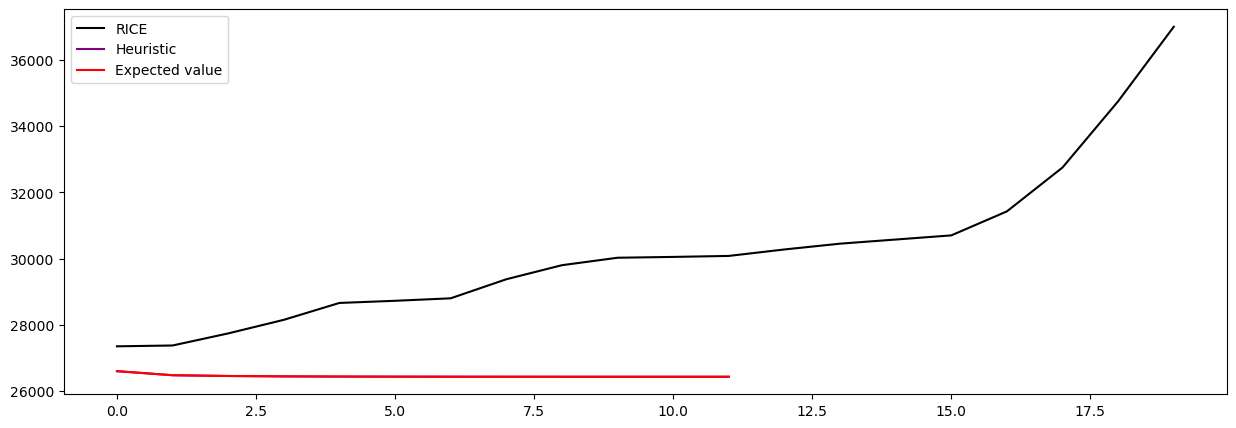

In [59]:
#pfts1_rice = cUtil.load_obj('pwfts')
tmpe = pfts1_rice.predict(d_array[train_split:train_split+20], type='point', method='heuristic',
                          steps_ahead=12)
tmpq = pfts1_rice.predict(d_array[train_split:train_split+20], type='point', method='expected_value',
                          steps_ahead=12)

f, ax = plt.subplots(1, 1, figsize=[15,5])

ax.plot(np.arange(0,20), d_array[train_split:train_split+20], color="black", label="RICE")


ax.plot(tmpe, color='purple', label="Heuristic")
ax.plot(tmpq, color='red', label="Expected value")

#ax.set_ylim([mi*0.9, ma*1.1])

handles0, labels0 = ax.get_legend_handles_labels()

lgd = ax.legend(handles0, labels0, loc=2)

In [ ]:
# PSO Algorithm
for all particles{
    initialize velocities and positions;
}
while stopping criteria not satisffied{
    for each particle{
        Compute velocity;
        increment position;
        if present fitness value is better than current best local:
            update local best position;
        if present fitness value is better than current global best value:
            update global best value;

    }
}